Wizualizacje z plotly są wymagające pod względem zasobów więc możliwe jest, że nie wszystkie wyświetlą się po otwarciu notatnika - może być konieczne samodzielne uruchomienie kodu.

In [1]:
!pip install kaleido

In [2]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.neighbors import KDTree
import numpy as np
from IPython.display import Image, display
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.stats.multitest import multipletests

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
erb = pd.read_csv("/content/drive/MyDrive/single-cell-tracks_exp1-6_noErbB2.csv.gz")

In [ ]:
erb.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y,is_active
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248,False
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174,False
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787,True
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453,True
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885,True


In [ ]:
erb.describe()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
count,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07,3.554165e+07
mean,3.593846e+00,9.654818e+00,7.631083e+02,1.283255e+02,3.560427e+02,9.047551e-01,1.291381e+00,5.129958e+02,5.097858e+02
std,1.766744e+00,5.682569e+00,6.784322e+02,7.446081e+01,1.289045e+02,2.278312e-01,2.036630e-01,2.970606e+02,2.972352e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,2.078950e+00,2.119400e+00
25%,2.000000e+00,5.000000e+00,2.870000e+02,6.400000e+01,2.789990e+02,7.534900e-01,1.169790e+00,2.558600e+02,2.520280e+02
50%,4.000000e+00,9.000000e+00,5.940000e+02,1.280000e+02,3.330000e+02,8.670850e-01,1.292390e+00,5.147730e+02,5.084320e+02
75%,5.000000e+00,1.400000e+01,1.024000e+03,1.930000e+02,4.069990e+02,1.025020e+00,1.415030e+00,7.711060e+02,7.672950e+02
max,6.000000e+00,2.400000e+01,6.345000e+03,2.570000e+02,2.308000e+03,6.196320e+00,5.403080e+00,1.020310e+03,1.020930e+03


In [15]:
mutation_to_site = {"WT":[1,2,3,4], "AKT":[5,6,7,8],
    "PIK_E545K":[9,10,11,12], "PIK_H1047R":[13,14,15,16],
    "PTEN_del":[17,18,19,20,21,22,23,24]}

##1

In [ ]:
def plot_mean(track, col):
    mu, sigma = track.mean()[col], track.std()[col]
    # px.line(mu)
    fig = go.Figure([
        go.Scatter(
            name='Mean',
            y=mu,
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='CI Upper',
            y=mu-sigma,
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='CI Lower',
            y=mu+sigma,
            marker=dict(color='#444'),
            line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
        )
    ])

    fig.update_layout(
        title=col,
        xaxis_title='Time',
        yaxis_title=col,
        legend_title="Legend Title",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"
        )
    )
    # fig.show()
    return Image(fig.to_image(format="png", width=800, height=400))

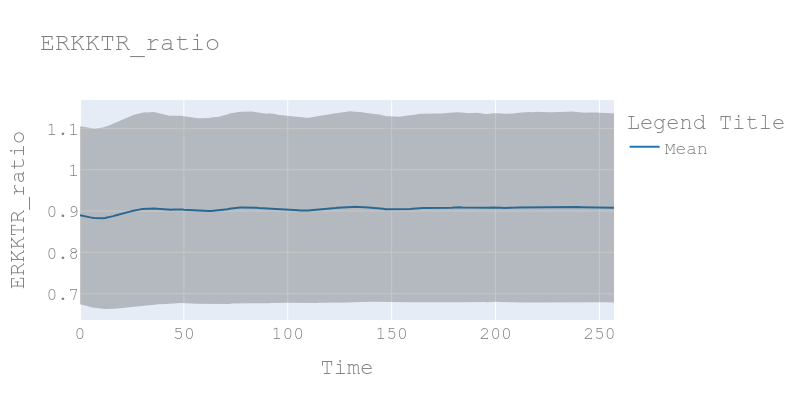

In [ ]:
track = erb.groupby("Image_Metadata_T")
plot_mean(track, "ERKKTR_ratio")

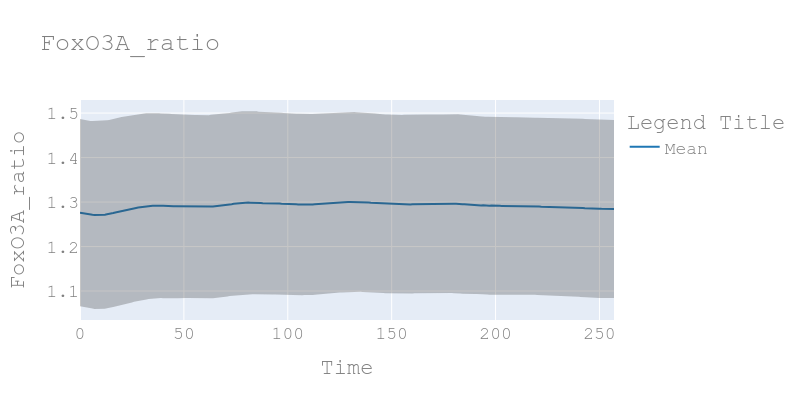

In [ ]:
plot_mean(track, "FoxO3A_ratio")

Wykresy średnich przebiegów czasowych $ERK_{ratio}$ i $AKT_{ratio}$ z 95% przedziałami ufności

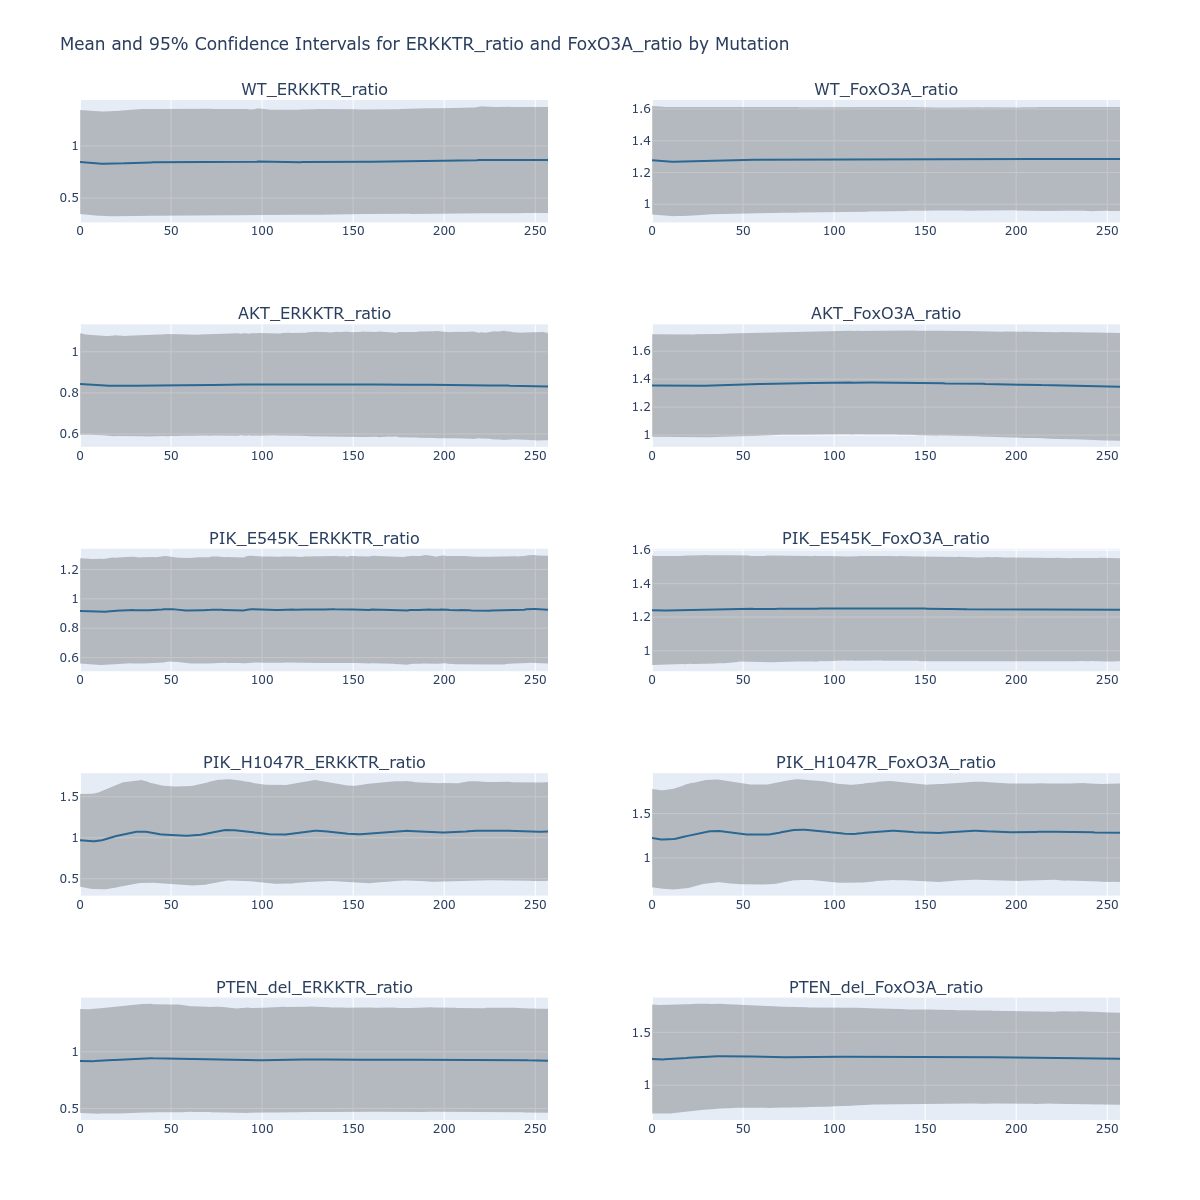

In [ ]:
fig = make_subplots(rows=5, cols=2, subplot_titles=[f"{mutation}_{name}" for mutation in mutation_to_site for name in ["ERKKTR_ratio", "FoxO3A_ratio"]])
for i, mutation in enumerate(mutation_to_site):
    track = erb[erb["Image_Metadata_Site"].isin(mutation_to_site[mutation])]
    track = track.groupby("Image_Metadata_T")
    mu, sigma = track["ERKKTR_ratio"].mean(), track["ERKKTR_ratio"].std()

    fig.add_trace(go.Scatter(y=mu, mode='lines', line=dict(color='rgb(31, 119, 180)'), showlegend=False), row=i+1, col=1)
    fig.add_trace(go.Scatter(y=mu + 2*sigma, mode='lines', marker=dict(color='#444'), line=dict(width=0), showlegend=False), row=i+1, col=1)
    fig.add_trace(go.Scatter(y=mu - 2*sigma, mode='lines', marker=dict(color='#444'), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False), row=i+1, col=1)

    mu, sigma = track["FoxO3A_ratio"].mean(), track["FoxO3A_ratio"].std()

    fig.add_trace(go.Scatter(y=mu, mode='lines', line=dict(color='rgb(31, 119, 180)'), showlegend=False), row=i+1, col=2)
    fig.add_trace(go.Scatter(y=mu + 2*sigma, mode='lines', marker=dict(color='#444'), line=dict(width=0), showlegend=False), row=i+1, col=2)
    fig.add_trace(go.Scatter(y=mu - 2*sigma, mode='lines', marker=dict(color='#444'), line=dict(width=0), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False), row=i+1, col=2)

fig.update_layout(height=1200, width=1200, title_text="Mean and 95% Confidence Intervals for ERKKTR_ratio and FoxO3A_ratio by Mutation")
Image(fig.to_image(format="png"), width=1200, height=1200)

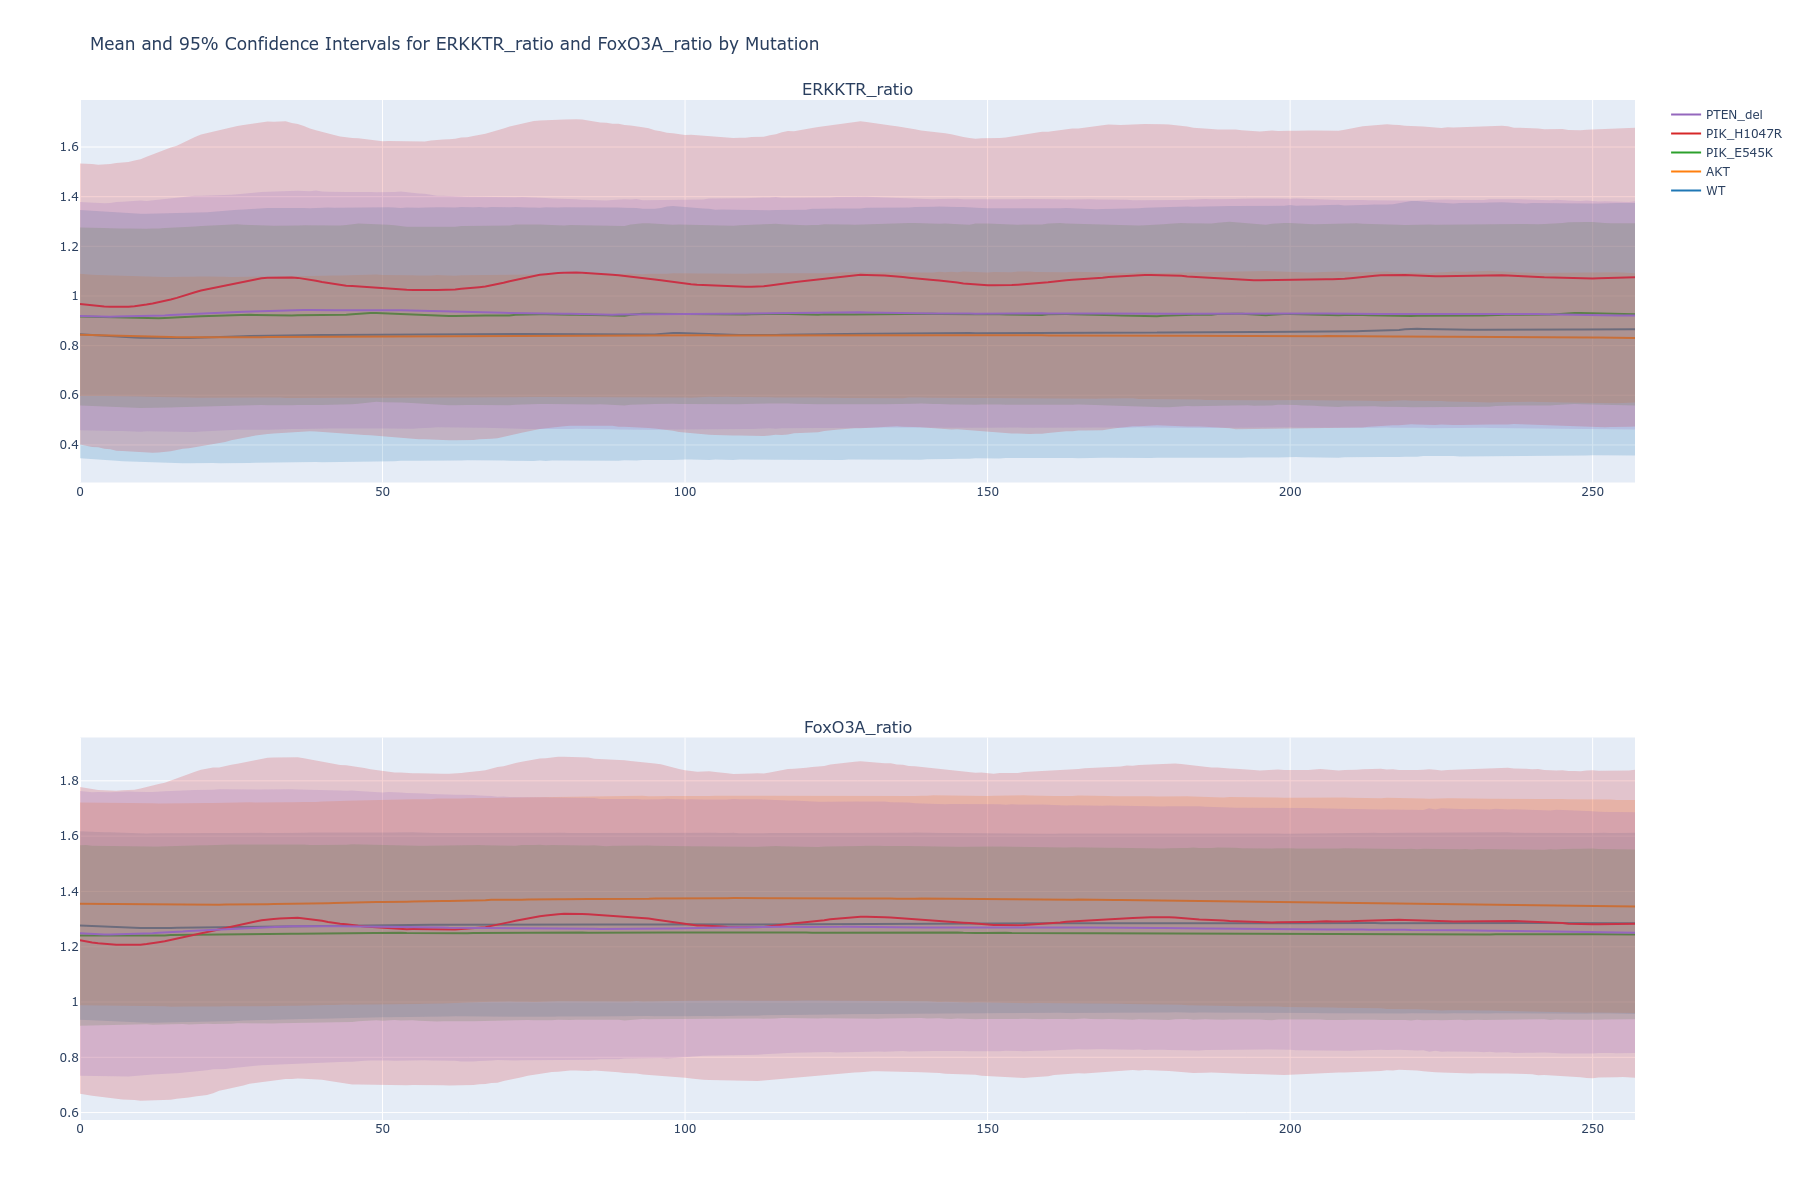

In [ ]:
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

fig = make_subplots(rows=2, cols=1, subplot_titles=["ERKKTR_ratio", "FoxO3A_ratio"])

for i, mutation in enumerate(mutation_to_site):
    color = colors[i % len(colors)]

    track = erb[erb["Image_Metadata_Site"].isin(mutation_to_site[mutation])]
    track = track.groupby("Image_Metadata_T")

    mu_erk, sigma_erk = track["ERKKTR_ratio"].mean(), track["ERKKTR_ratio"].std()

    rgb = color[4:-1].split(',')
    r, g, b = int(rgb[0].strip()), int(rgb[1].strip()), int(rgb[2].strip())

    fig.add_trace(go.Scatter(y=mu_erk, mode='lines', line=dict(color=color), showlegend=True, name=f"{mutation}"), row=1, col=1)
    fig.add_trace(go.Scatter(y=mu_erk + 2*sigma_erk, mode='lines', marker=dict(color='#444'), line=dict(width=0), showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(y=mu_erk - 2*sigma_erk, mode='lines', marker=dict(color='#444'), line=dict(width=0), fillcolor=f"rgba({r}, {g}, {b}, 0.2)", fill='tonexty', showlegend=False), row=1, col=1)

    mu_fox, sigma_fox = track["FoxO3A_ratio"].mean(), track["FoxO3A_ratio"].std()

    fig.add_trace(go.Scatter(y=mu_fox, mode='lines', line=dict(color=color), showlegend=False, name=f"{mutation}"), row=2, col=1)
    fig.add_trace(go.Scatter(y=mu_fox + 2*sigma_fox, mode='lines', marker=dict(color='#444'), line=dict(width=0), showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(y=mu_fox - 2*sigma_fox, mode='lines', marker=dict(color='#444'), line=dict(width=0), fillcolor=f"rgba({r}, {g}, {b}, 0.2)", fill='tonexty', showlegend=False), row=2, col=1)

fig.update_layout(height=1200, width=1800, title_text="Mean and 95% Confidence Intervals for ERKKTR_ratio and FoxO3A_ratio by Mutation")
Image(fig.to_image(format="png"), width=1200, height=1800)

Test Manna-Whitney'a dla każdej pary mutacji

/tmp/ipykernel_106963/3643552216.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group1 = data[data["Image_Metadata_Site"].isin(mutation_to_site[mutation1])][data["Image_Metadata_T"].isin(trange)].groupby("Exp_ID").mean()[col].to_numpy()
/tmp/ipykernel_106963/3643552216.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group2 = data[data["Image_Metadata_Site"].isin(mutation_to_site[mutation2])][data["Image_Metadata_T"].isin(trange)].groupby("Exp_ID").mean()[col].to_numpy()
/tmp/ipykernel_106963/3643552216.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group1 = data[data["Image_Metadata_Site"].isin(mutation_to_site[mutation1])][data["Image_Metadata_T"].isin(trange)].groupby("Exp_ID").mean()[col].to_numpy()
/tmp/ipykernel_106963/3643552216.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group2 = data[data["Image_Metadata_Site"].isin(mutation_to_si

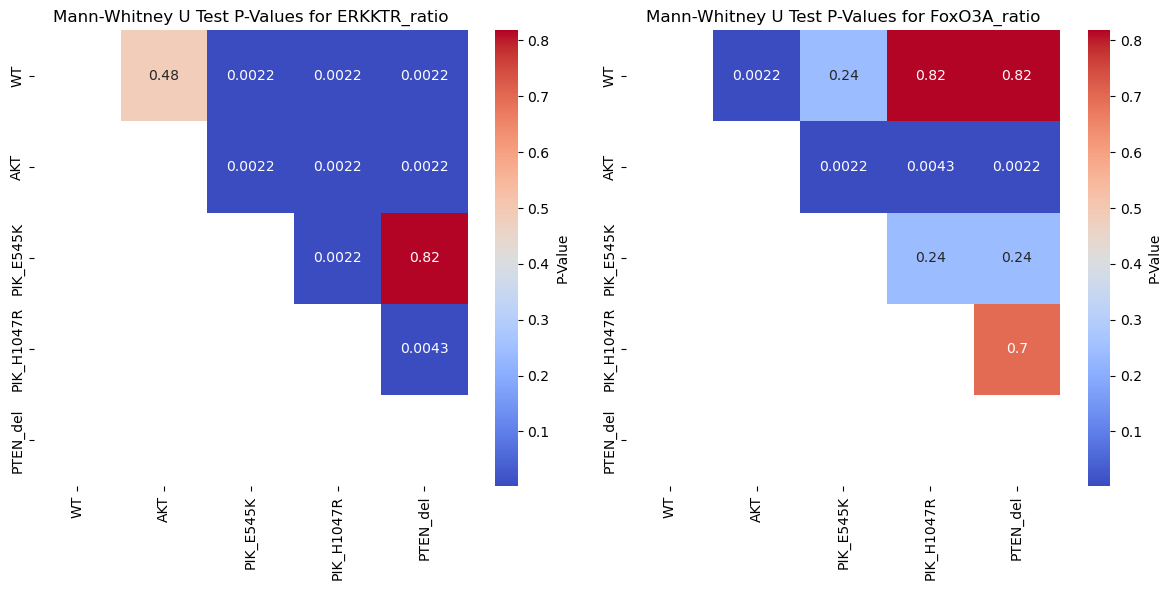

In [ ]:
from multiprocessing import Pool, cpu_count

def perform_mann_whitney_test(data, mutation1, mutation2, col, trange=list(range(60, 180))):
    group1 = data[data["Image_Metadata_Site"].isin(mutation_to_site[mutation1])][data["Image_Metadata_T"].isin(trange)].groupby("Exp_ID").mean()[col].to_numpy()
    group2 = data[data["Image_Metadata_Site"].isin(mutation_to_site[mutation2])][data["Image_Metadata_T"].isin(trange)].groupby("Exp_ID").mean()[col].to_numpy()
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    p_value = multipletests(p_value, method='bonferroni')[1]
    return (mutation1, mutation2, p_value)

def wrapper_mann_whitney_test(args):
    return perform_mann_whitney_test(*args)

p_values_ERKKTR_ratio = pd.DataFrame(index=mutation_to_site.keys(), columns=mutation_to_site.keys())
args_list = [(erb, mutation1, mutation2, "ERKKTR_ratio") for mutation1, mutation2 in combinations(mutation_to_site.keys(), 2)]

with Pool(cpu_count()) as pool:
    results = pool.map(wrapper_mann_whitney_test, args_list)

for mutation1, mutation2, p_value in results:
    p_values_ERKKTR_ratio.loc[mutation1, mutation2] = p_value

p_values_FoxO3A_ratio = pd.DataFrame(index=mutation_to_site.keys(), columns=mutation_to_site.keys())
args_list = [(erb, mutation1, mutation2, "FoxO3A_ratio") for mutation1, mutation2 in combinations(mutation_to_site.keys(), 2)]

with Pool(cpu_count()) as pool:
    results = pool.map(wrapper_mann_whitney_test, args_list)

for mutation1, mutation2, p_value in results:
    p_values_FoxO3A_ratio.loc[mutation1, mutation2] = p_value

p_values_ERKKTR_ratio = p_values_ERKKTR_ratio.astype(float)
p_values_FoxO3A_ratio = p_values_FoxO3A_ratio.astype(float)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(p_values_ERKKTR_ratio, annot=True, cmap='coolwarm', cbar_kws={'label': 'P-Value'})
plt.title('Mann-Whitney U Test P-Values for ERKKTR_ratio')

plt.subplot(1, 2, 2)
sns.heatmap(p_values_FoxO3A_ratio, annot=True, cmap='coolwarm', cbar_kws={'label': 'P-Value'})
plt.title('Mann-Whitney U Test P-Values for FoxO3A_ratio')

plt.tight_layout()
plt.show()



##2

Definicja aktywności jako 75 centyl

In [16]:
erb["is_active"] = erb["ERKKTR_ratio"] > erb["ERKKTR_ratio"].quantile(0.75)

Odległość od najbliższego aktywnego sąsiada

In [17]:
def calc_dist(dist):
    dist_act = dist[~(dist[:,2] == np.ones(dist.shape[0]))][:,:2]
    dist = dist[:,:2]
    tree = KDTree(dist_act)
    distance, _ = tree.query(dist, k=2)
    return distance[:,1].mean()

<ipython-input-18-a88c990e7abb>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-18-a88c990e7abb>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-18-a88c990e7abb>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `i

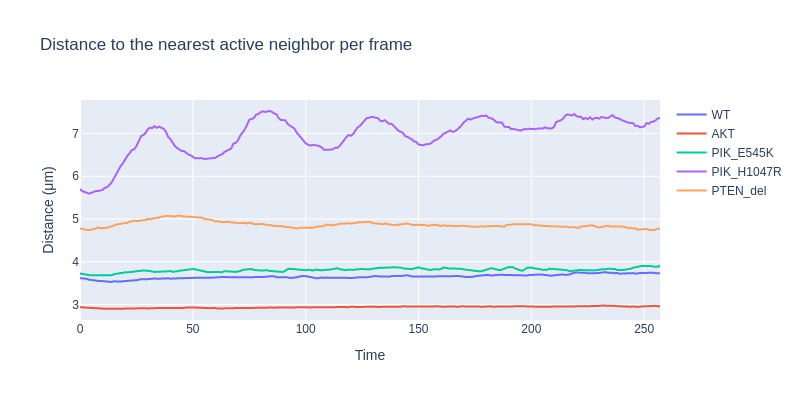

In [18]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.05)
for mutation in mutation_to_site.keys():
    dist = erb[erb["Image_Metadata_Site"].isin(mutation_to_site[mutation])].groupby("Image_Metadata_T").apply(lambda x: calc_dist(x[["objNuclei_Location_Center_X", "objNuclei_Location_Center_Y", "is_active"]].to_numpy()))
    fig.add_trace(go.Scatter(x=dist.index, y=dist, mode='lines', name=mutation), row=1, col=1)
fig.update_layout(xaxis_title="Time", yaxis_title="Distance (μm)", title="Distance to the nearest active neighbor per frame", height=600, width=1200)
Image(fig.to_image(format="png", width=800, height=400))

Liczba aktywnych sąsiadów w promieniu 10 $\mu m$

In [19]:
dist_threshold = 10

def n_neighbors(dist, threshold):
    dist_act = dist[~(dist[:,2] == np.ones(dist.shape[0]))][:,:2]
    dist = dist[:,:2]
    tree = KDTree(dist_act)
    n_neighbors = tree.query_radius(dist, threshold, count_only=True)
    return n_neighbors.mean()

<ipython-input-20-1efeefe24e14>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-20-1efeefe24e14>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-20-1efeefe24e14>:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `i

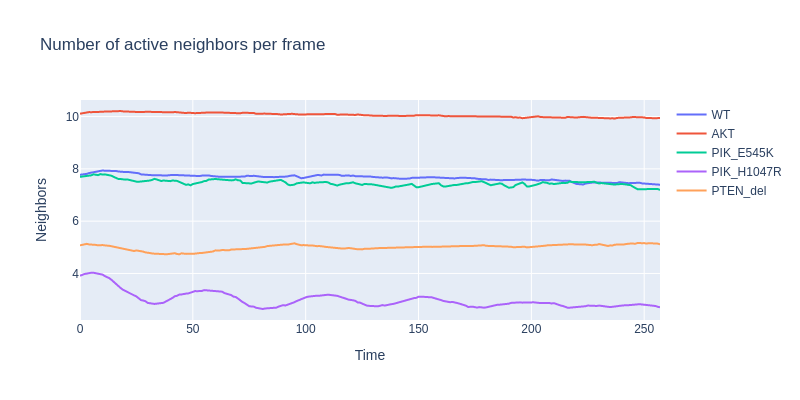

In [20]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.05)
for mutation in mutation_to_site.keys():
    dist = erb[erb["Image_Metadata_Site"].isin(mutation_to_site[mutation])].groupby("Image_Metadata_T").apply(lambda x: n_neighbors(x[["objNuclei_Location_Center_X", "objNuclei_Location_Center_Y", "is_active"]].to_numpy(),dist_threshold))
    fig.add_trace(go.Scatter(x=dist.index, y=dist, mode='lines', name=mutation), row=1, col=1)
fig.update_layout(xaxis_title="Time", yaxis_title="Neighbors", title="Number of active neighbors per frame", height=600, width=1200)
Image(fig.to_image(format="png", width=800, height=400))

Liczba komórek o poszczególnych mutacjach w czasie

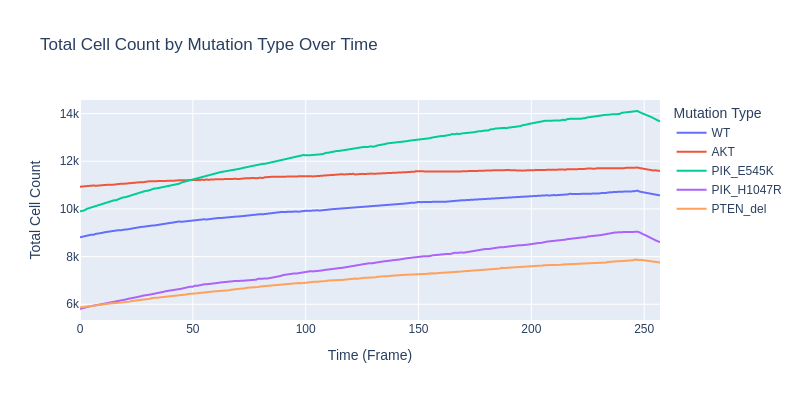

In [22]:
fig_cell_count = go.Figure()

if 'mutation_type' not in erb.columns:
    site_to_mutation = {site: mutation for mutation, sites in mutation_to_site.items() for site in sites}
    erb['mutation_type'] = erb['Image_Metadata_Site'].map(site_to_mutation)

unique_cells_per_time = erb.drop_duplicates(subset=['Image_Metadata_T', 'mutation_type', 'track_id', 'Exp_ID'])
cell_counts = unique_cells_per_time.groupby(['Image_Metadata_T', 'mutation_type']).size().reset_index(name='cell_count')

colors = px.colors.qualitative.Plotly

for i, mutation in enumerate(mutation_to_site.keys()):
    mutation_data = cell_counts[cell_counts['mutation_type'] == mutation]
    if not mutation_data.empty:
        fig_cell_count.add_trace(go.Scatter(
            x=mutation_data['Image_Metadata_T'],
            y=mutation_data['cell_count'],
            mode='lines',
            name=mutation,
            marker=dict(color=colors[i % len(colors)])
        )
      )

fig_cell_count.update_layout(
    title='Total Cell Count by Mutation Type Over Time',
    xaxis_title='Time (Frame)',
    yaxis_title='Total Cell Count',
    legend_title="Mutation Type",
)

# fig_cell_count.show()
Image(fig_cell_count.to_image(format="png", width=800, height=400))

Wykrycie komórek, które przekroczyły próg aktywacji w danym kroku czasowym

In [ ]:
erb['is_active_prev'] = erb.groupby(["track_id", "Image_Metadata_Site", "Exp_ID"])['is_active'].shift(1)

erb['activation_event'] = 0
erb.loc[
    (erb['is_active'] == True) & (erb['is_active_prev'] == False),
    'activation_event'
] = 1

Histogram wartości $ERK_{ratio}$ w zależności od stanu aktywności

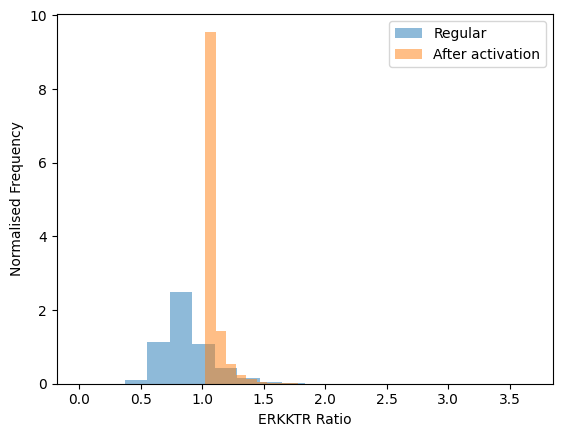

In [ ]:
for activation_status in [0, 1]:
    subset = erb[(erb["Exp_ID"]==1) & (erb["activation_event"]==activation_status) & (erb["Image_Metadata_Site"].isin([1,5,9,13,17]))]
    tree = KDTree(subset[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values)
    indices = tree.query_radius(subset[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values, r=3)
    neighbor_erkktr_values = subset['ERKKTR_ratio'].to_numpy()[np.hstack(indices.flatten())]

    plt.hist(neighbor_erkktr_values, bins=20, alpha=0.5, label=f"After activation" if activation_status==1 else "Regular", density=True)
    plt.xlabel("ERKKTR Ratio")
    plt.ylabel("Normalised Frequency")
plt.legend()
plt.show()


Wizualizacja rozmieszczenia przestrzennego komórek z podziałem na aktywność w funkcji czasu (prawdopodobnie trzeba samodzielnie uruchomić kod)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

steps = []
for i in erb['Image_Metadata_T'].unique():
    step = dict(
        method="update",
        args=[{"visible": [False] * len(erb['Image_Metadata_T'].unique())},
              {"title": f"Nucleus Position at Time {i}"}],
        label=str(i)
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Timestamp: "},
    pad={"t": 50},
    steps=steps
)]

for i, time_point in enumerate(erb['Image_Metadata_T'].unique()):
    subset = erb[(erb['Image_Metadata_T'] == time_point) & (erb["Image_Metadata_Site"]==1)]
    fig.add_trace(
        go.Scatter(
            x=subset['objNuclei_Location_Center_X'],
            y=subset['objNuclei_Location_Center_Y'],
            mode='markers',
            name=f"Time={time_point}",
            visible=False,
            marker=dict(size=5, color=subset["activation_event"])
        ),
    )

fig.data[0].visible = True

fig.update_layout(
    title="Nucleus Position Over Time",
    xaxis_title="X Position (μm)",
    yaxis_title="Y Position (μm)",
    sliders=sliders
)

fig.show()


##3

Filtrowanie w celu usunięcia serii poniżej 200 kroków (zakładam, że mogłyby zaburzyć wyniki)

In [7]:
erb["len_200"] = erb.groupby(["track_id", "Image_Metadata_Site", "Exp_ID"])["Image_Metadata_T"].transform('count')
erb["len_200"] = (erb["len_200"] > 200).astype(int)
erb_full_length = erb[erb["len_200"]==1]
erb = None

In [4]:
from scipy.stats import kruskal
from scipy.signal import detrend

Sprawdzanie okresowości przy użyciu testu Kruskala-Wallisa

In [8]:
def kruskal_season(x):
  pvals = []
  x = detrend(x,type="linear")
  for period in range(45,57):
    pvals.append(kruskal(*[x[i::period] for i in range(period)])[1])
  return min(pvals) < 0.05

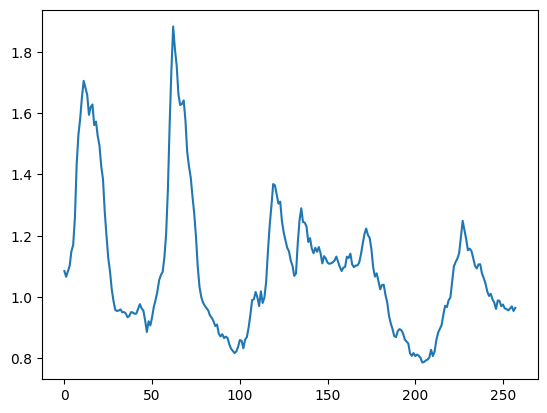

True


In [9]:
series = erb_full_length[(erb_full_length["Exp_ID"]==1) & (erb_full_length["Image_Metadata_Site"]==15) & (erb_full_length["track_id"]==5)]
plt.plot(series['FoxO3A_ratio'].to_numpy())
plt.show()
print(kruskal_season(series['FoxO3A_ratio'].to_numpy()))

In [10]:
from tqdm.auto import tqdm
tqdm.pandas()

In [11]:
gb = erb_full_length.groupby(["track_id", "Image_Metadata_Site", "Exp_ID"])["FoxO3A_ratio"]
erb_full_length["periodic"] = gb.progress_transform(lambda x: kruskal_season(x.to_numpy())).astype(int)
gb = None

  0%|          | 0/120372 [00:00<?, ?it/s]

In [12]:
erb_full_length["periodic"].mean()

np.float64(0.1512344108179524)

In [7]:
# erb_full_length.to_csv("/content/erb.csv")
erb_full_length = pd.read_csv("/content/erb.csv")

In [13]:
site_to_mutation = {}
for mutation, sites in mutation_to_site.items():
    for site in sites:
        site_to_mutation[site] = mutation

erb_full_length['mutation'] = erb_full_length['Image_Metadata_Site'].map(site_to_mutation)


Rozkład mutacji w seriach okresowych i nieokresowych

In [8]:
aperiodic = erb_full_length[erb_full_length['periodic'] == 0]
periodic = erb_full_length[erb_full_length['periodic'] == 1]

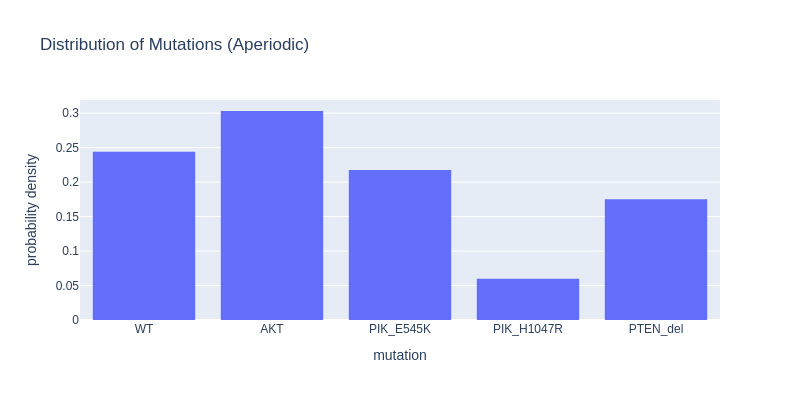

In [9]:
fig_lowest = px.histogram(aperiodic,
                         x='mutation',
                         title='Distribution of Mutations (Aperiodic)',
                         nbins=20,
                         barmode='group',
                         histnorm='probability density')
Image(fig_lowest.to_image(format="png", width=800, height=400))
# fig_lowest.show()

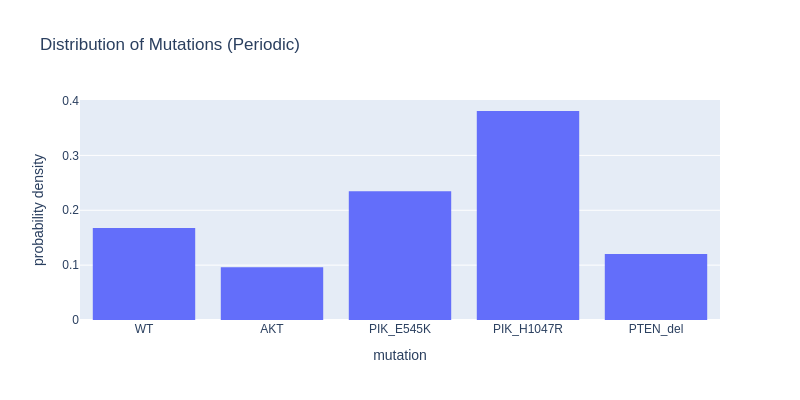

In [10]:
fig_highest = px.histogram(periodic,
                          x='mutation',
                          title='Distribution of Mutations (Periodic)',
                          nbins=20,
                          barmode='group',
                          histnorm='probability density')
Image(fig_highest.to_image(format="png", width=800, height=400))
# fig_highest.show()

Przykładowe serie okresowe i nieokresowe

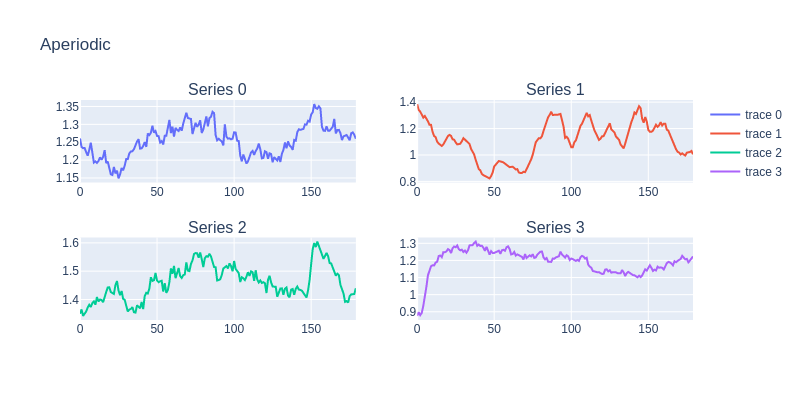

In [11]:
def plot_time_series(df, title):
    fig = make_subplots(rows=2, cols=2, subplot_titles=[f"Series {i}" for i in range(10)])
    for i in range(4):
        track_id = np.random.choice(df['track_id'].unique())
        subset = df[df['track_id'] == track_id]
        if not subset.empty:
          fig.add_trace(go.Scatter(y=subset['FoxO3A_ratio'], mode='lines'),
                        row=(i // 2) + 1, col=(i % 2) + 1)
    fig.update_layout(height=400, width=800, title_text=title)
    # fig.show()
    return Image(fig.to_image(format="png", width=800, height=400))


plot_time_series(aperiodic.groupby("track_id").head(180), "Aperiodic")


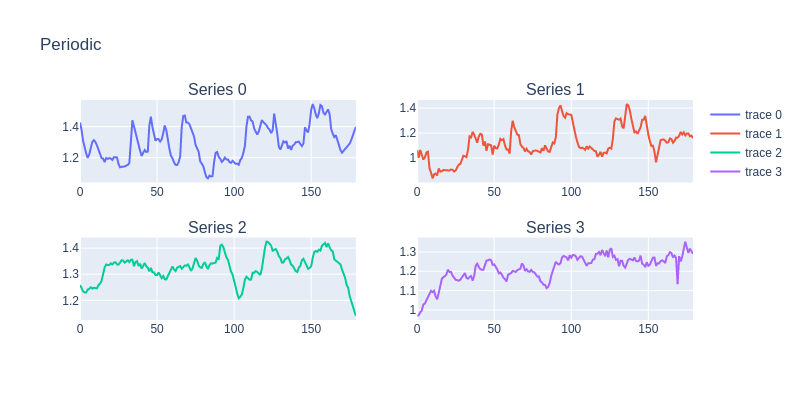

In [12]:
plot_time_series(periodic.groupby("track_id").head(180), "Periodic")